In [1]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from utils import *

Llyods Banking Group (2) (2009-11-23 -- 2011-12-30)


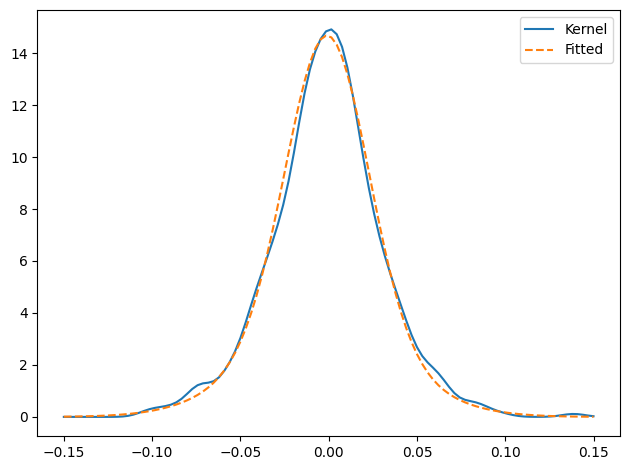

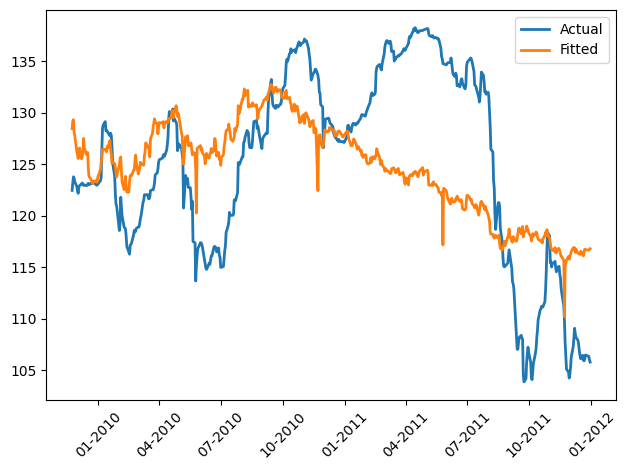

Credit Suisse (2011-02-22 -- 2011-12-30)


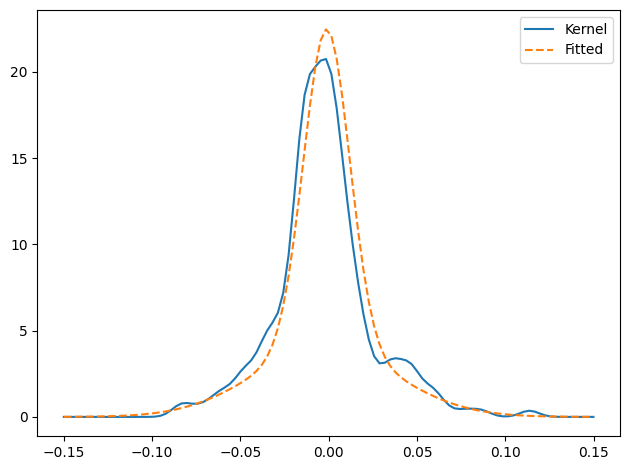

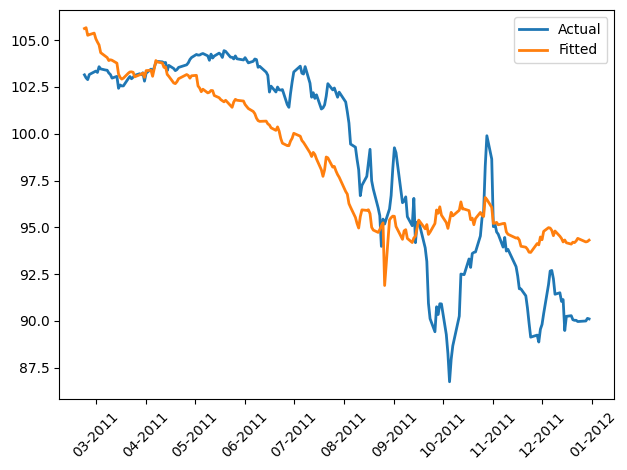

Llyods Banking Group (1) (2021-01-04 -- 2023-12-29)


/var/folders/tf/qb228ljd37x5jf66_kb20fq80000gn/T/ipykernel_20204/3269222046.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cet_data['Date'] = pd.to_datetime(cet_data['Names Date'])
/Users/caesa/Desktop/CoCo/code/utils.py:403: RuntimeWarning: divide by zero encountered in log
  log_firstm = np.log(l) + a * np.log(b) +  np.log(t) + (a-1) * np.log(x) - b * x - np.log(sc.factorial(a-1))


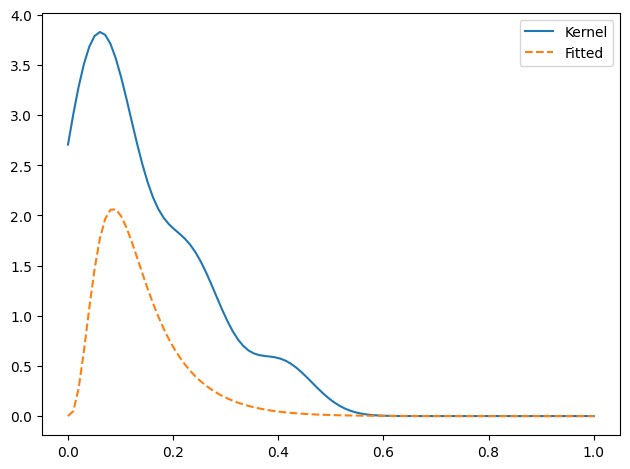

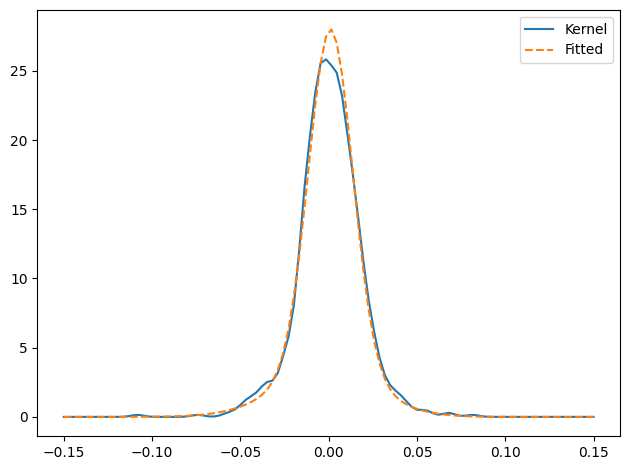

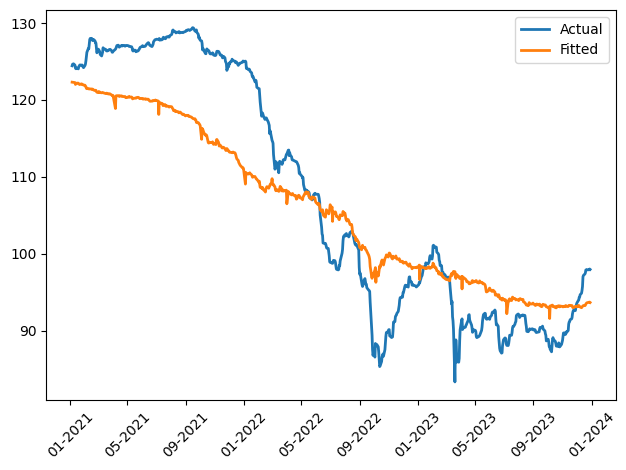

Credit Suisse (Gov Intervention) (1/1/2020 -- 3/17/2023)


/var/folders/tf/qb228ljd37x5jf66_kb20fq80000gn/T/ipykernel_20204/3269222046.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cet_data['Date'] = pd.to_datetime(cet_data['Names Date'])
/Users/caesa/Desktop/CoCo/code/utils.py:403: RuntimeWarning: divide by zero encountered in log
  log_firstm = np.log(l) + a * np.log(b) +  np.log(t) + (a-1) * np.log(x) - b * x - np.log(sc.factorial(a-1))
/Users/caesa/Desktop/CoCo/code/utils.py:403: RuntimeWarning: invalid value encountered in multiply
  log_firstm = np.log(l) + a * np.log(b) +  np.log(t) + (a-1) * np.log(x) - b * x - np.log(sc.factorial(a-1))


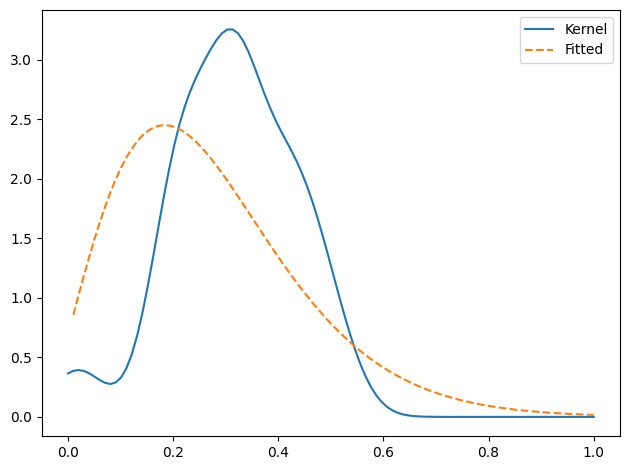

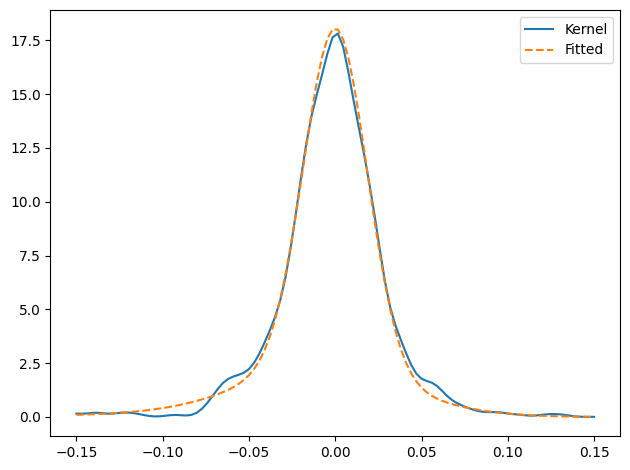

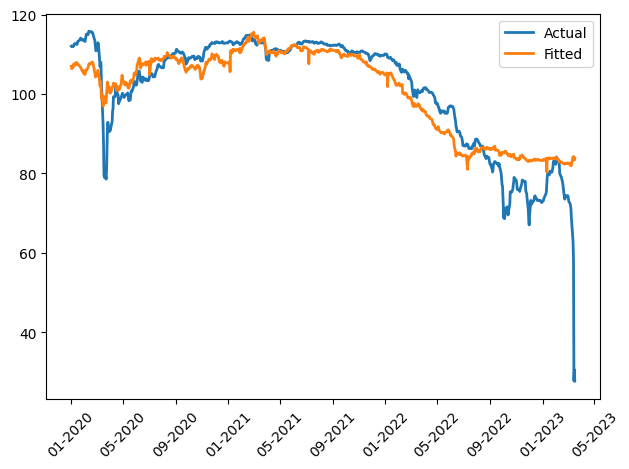

CCB (2019-11-20 -- 2023-09-01)


/var/folders/tf/qb228ljd37x5jf66_kb20fq80000gn/T/ipykernel_20204/3269222046.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cet_data['Date'] = pd.to_datetime(cet_data['Names Date'])
/Users/caesa/Desktop/CoCo/code/utils.py:403: RuntimeWarning: divide by zero encountered in log
  log_firstm = np.log(l) + a * np.log(b) +  np.log(t) + (a-1) * np.log(x) - b * x - np.log(sc.factorial(a-1))


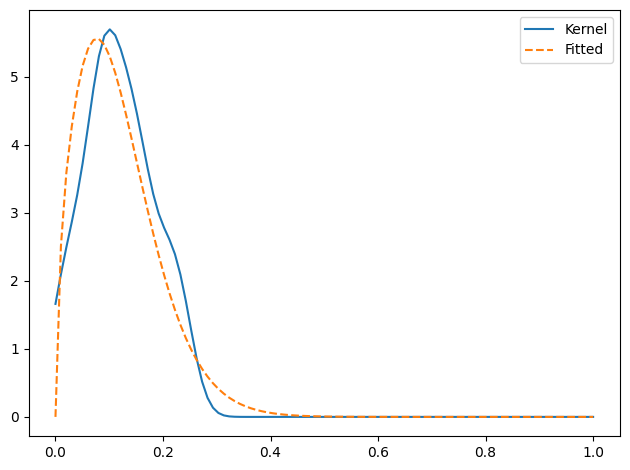

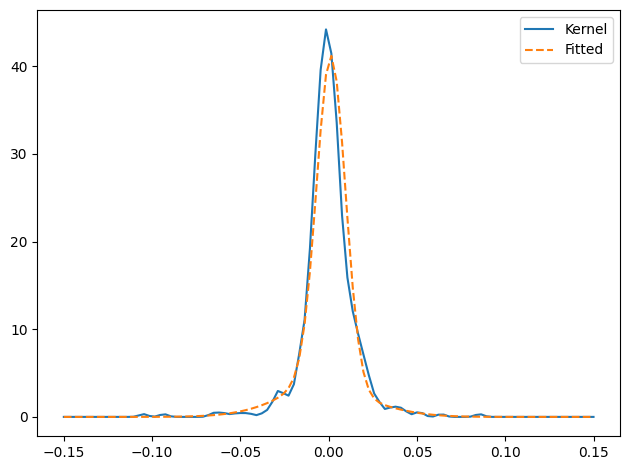

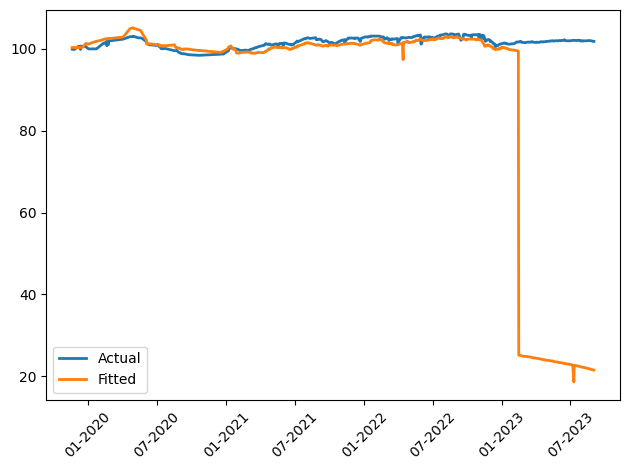

In [2]:
q = 0
K = 100
ft_size = 12
maturity_c_dict = {'case1': [10, 0.15/2, 20, 'Llyods Banking Group (2)'],
                  'case2': [5, 7.875/100/2, 10, 'Credit Suisse'],
                  'case3': [5, 7/100/4, 20, 'Llyods Banking Group (1)'],
                  'case4': [7, 7.25/100/2, 14, 'Credit Suisse (Gov Intervention)'], # has government intervention
                  'case5': [5, 4.22/100, 5, 'CCB']
                  }



#for process_case in ['case1', 'case2', 'case3', 'case4']:
for process_case in ['case1','case2', 'case3', 'case4', 'case5']:
#for process_case in ['case3']:
    
    # [read parameterrs]
    coco_param = pd.read_csv('../param/CoCo_' + process_case + '.csv')

    
    if process_case =='case4':
        (loss, l1, b, a, mu, sigma,
     l2, muV, sigmaV, eta, 
    k1, xi1, k2, xi2, l32) = list(pd.read_csv('../param/Intervention0130_Credit_Suisse_Data_13-23.csv').squeeze())
        
        ignore_gov = False
        pricing_period = ['1/1/2020', '3/17/2023']
        loss_coco, p, w, Jbar, wbar, gamma = coco_param.iloc[0].values
    
    else:
        stock_param = pd.read_csv('../param/J_' + process_case + '.csv')
        loss, mu, sigma, l2, muV, sigmaV, eta, l1, b, a = stock_param.iloc[0].values
        k1, xi1, k2, xi2, l32, ignore_gov = [None, None, None, None, None, True]
        pricing_period = None
        gamma = 1
        loss_coco, p, w, Jbar, wbar = coco_param.iloc[0].values
        

    
        
    
    
    # [read data]
    data = pd.read_excel('../data/Charlie1124/'+ process_case + '/data-'+ process_case + '.xlsx')
    data = data.set_index('Date')
    
    if pricing_period == None:
        pricing_period = [datetime.datetime.strftime(data.index[0], format = "%Y-%m-%d"), 
                          datetime.datetime.strftime(data.index[-1], format = "%Y-%m-%d")]

    date_flag = data.index.isin(pd.date_range(start=pricing_period[0], end=pricing_period[1]))
    data = data[date_flag]
     
    data = data.dropna(how = 'any')
    St = data['Stock'].values
    RET= data['return without dividend']/100
    r = data['r'].values/100
    coco_price = data['CoCo'].values
    T, c, M, title= maturity_c_dict[process_case]
    maturity = pd.to_datetime(data.index[0]) + pd.DateOffset(years = T)
    t0 = np.array(range(data.index.shape[0]))/252


    print(title + ' (' + pricing_period[0] + ' -- ' + pricing_period[1] + ')')
    
    if process_case in ['case3', 'case4', 'case5']:
        cet_data = pd.read_excel('../data/Charlie1124/' + process_case + '/data-' + process_case + '.xlsx', sheet_name=1)
        B = cet_data['CET-1 ratio (phase-in)'].values/100
        
        cet_data['Date'] = pd.to_datetime(cet_data['Names Date'])
        cet_smoothed = cet_data.set_index('Date').resample('D').interpolate()
        cet_value = cet_smoothed.loc[cet_smoothed.index.isin(data.index), 'CET-1 ratio (phase-in)'].values / 100


        

        #[ H density plot]
        J = np.tan(np.pi * 0.5 - np.pi * B) + 1 / np.tan(np.pi * (1 - B[0]))
        Diff_J = np.diff(J)
        H = Diff_J - min(Diff_J) + 0.01
    
    
        H_grids = np.linspace(0, 1, 100)
        Eval_JDensity_a3 = np.exp(Density_J(l1, int(a), b, 1/4, H_grids)) #ToDO: comfirm 1/4
        Data_JDensity_data = KDE_estimate(H, H_grids)

        plt.plot(H_grids, Data_JDensity_data, label='Kernel')
        plt.plot(H_grids, Eval_JDensity_a3, linestyle='--', label='Fitted')
        plt.legend()
        plt.tight_layout()
        #plt.title('H', fontsize = ft_size)
        plt.savefig('../figure/casestudies/H_' + process_case + '.png', format='png', dpi=200)
        plt.show()


    else:
        cet_value = None

    
    RET_grids = np.linspace(-0.15, 0.15, 100)
    Eval_Density = Density_stock(l1, a, b, mu, sigma, l2, muV, sigmaV, eta, RET_grids)
    Data_DensityStock = KDE_estimate(RET.values, RET_grids)
    
    
    
    #fig= plt.figure(figsize = (24,6))
    #fig.suptitle(title + ' (' + pricing_period[0] + ' -- ' + pricing_period[1] + ')')
    
    
    
    # ax = fig.add_subplot(131)
    plt.plot(RET_grids, Data_DensityStock, label='Kernel')
    plt.plot(RET_grids, Eval_Density, linestyle='--', label='Fitted')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../figure/casestudies/S_' + process_case + '.png', format='png', dpi=200)
    plt.show()
 
    model_price = equityconvert_coco(r, K, T, t0,
                                     l1, a, b,
                                     c, eta, p, q,
                                     Jbar, M, w, wbar,
                                     k1, xi1, k2, xi2,
                                     l2, l32, muV, sigmaV, sigma,
                                     ignore_gov=ignore_gov, St = St,gamma = gamma,
                                     cet = cet_value
                                    )
    

    rmse_loss = np.sqrt(np.mean((model_price - coco_price) ** 2))

    #ax = fig.add_subplot(132)
    plt.plot(data.index, coco_price, label = 'Actual',  linewidth=2.0)
    plt.plot(data.index, model_price,  label = 'Fitted', linewidth=2.0)
    plt.legend()
    #plt.ylabel('CoCo price', fontsize=ft_size)
    #plt.xlabel('Date', fontsize=ft_size)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.tight_layout()
    #plt.title('CoCo Price' + ' --- rmse = ' + str(rmse_loss.round(4)), fontsize=ft_size)
    
    #plt.title('CoCo Price' + ' --- rmse = ' + str(rmse_loss.round(4)), y= - 0.3, fontsize=ft_size)
    plt.savefig('../figure/casestudies/CoCo' + process_case + '.png', format='png', dpi=200)
    plt.show()


    pred_df = pd.DataFrame([coco_price, model_price, St]).T
    pred_df.columns = ['actual', 'model', 'stock']
    pred_df.index = data.index
    pred_df.to_csv('../figure/casestudies/' + process_case + '.csv', index = False)

In [20]:
import pandas as pd
import time

spline_table = pd.read_csv('spline_approx_loop_changed0919.csv')
l1_grids, b_grids, t_grids, x_grids, a_grids, func_values, time = spline_table.values.T

with open('./SupPr_loop.pkl', 'rb') as inp:
    spline = pickle.load(inp)
func_approx = spline(l1_grids, a_grids, b_grids, t_grids, x_grids)

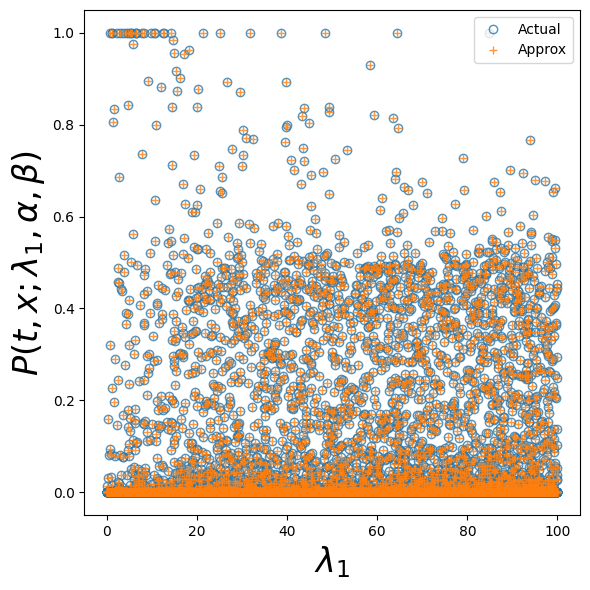

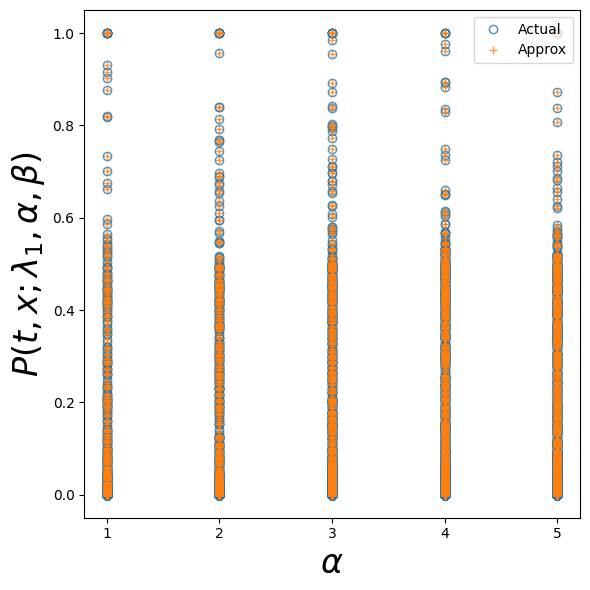

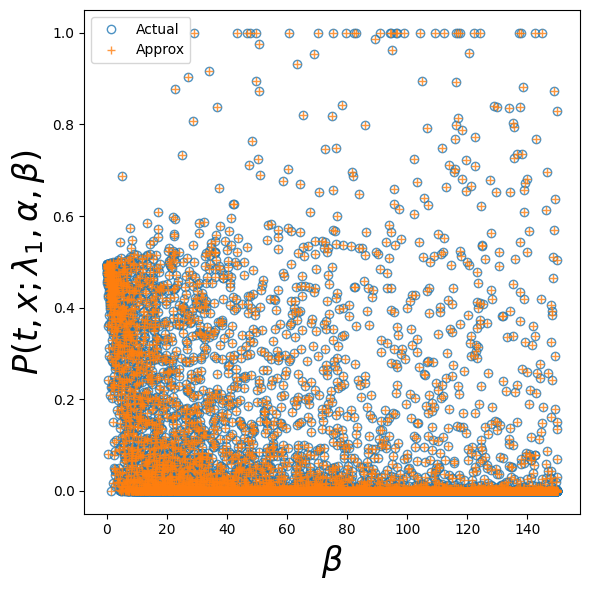

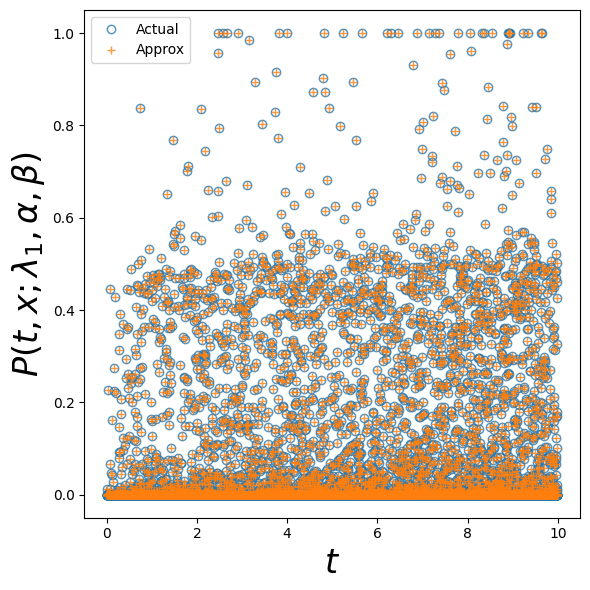

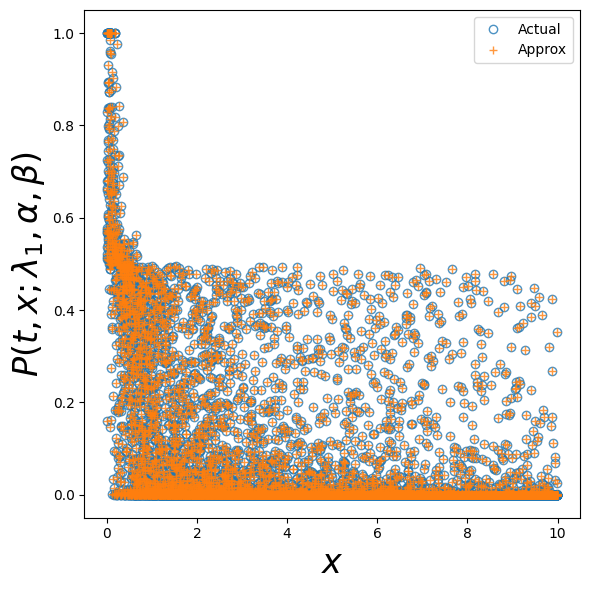

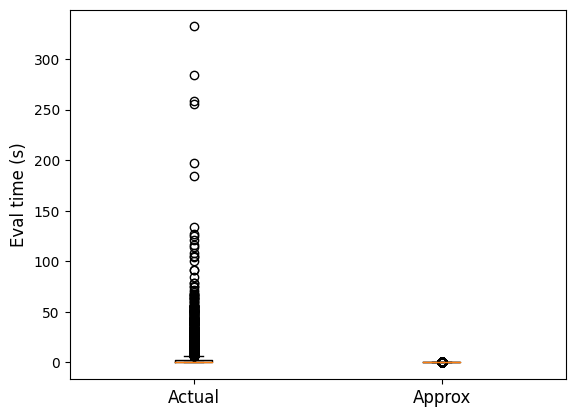

In [49]:
ft_size = 24
param_names = [r'$\lambda_1$', r'$\alpha$', r'$\beta$', r'$t$', r'$x$']
param_list = [l1_grids, a_grids, b_grids, t_grids, x_grids]
func_values[func_values>=1] = 1
for i in range(len(param_names)):
    fig = plt.figure(figsize=(6,6))
    plt.plot(param_list[i], func_values, 'o', label = 'Actual', fillstyle='none', alpha=0.8)
    plt.plot(param_list[i], func_approx, '+', label = 'Approx', alpha=0.8)
    plt.xlabel(param_names[i], fontsize = ft_size)
    plt.ylabel(r'$P(t, x; \lambda_1, \alpha, \beta)$', fontsize = ft_size)
    if i == 1:
        plt.xticks([1, 2, 3, 4, 5])
    plt.legend()
    fig.tight_layout()
    plt.savefig('../figure/spline_' + param_names[i].replace('\\', '').replace('$', '') + '.png', dpi=200)



# [time plot]
SupPr_time = {'Actual':[],
              'Approx':[]}

for i in range(len(l1_grids)):
    l1_, b_, t_, x_, a_, func_, func_time = spline_table.iloc[i].T

    SupPr_time['Actual'].append(func_time)

    
    start_spline = time.time()
    SupPr_approxi = spline(l1_grids[i], a_grids[i], b_grids[i], t_grids[i], x_grids[i])
    end_spline = time.time()
    SupPr_time['Approx'].append(end_spline - start_spline)

ft_size = 12
fig, ax = plt.subplots()
ax.boxplot(SupPr_time.values())
ax.tick_params(axis='x', labelsize=ft_size)
plt.ylabel('Eval time (s)', fontsize = ft_size)
ax.set_xticklabels(SupPr_time.keys())
plt.savefig('../figure/approx_time.png', dpi=200)
    



In [47]:
np.median(SupPr_time['Approx'])

3.409385681152344e-05

In [45]:
np.median(SupPr_time['Actual'])

0.9661624431610109

In [48]:
np.median(SupPr_time['Actual'])/ np.median(SupPr_time['Approx'])

28338.31468531469

In [6]:
pd.read_csv('../param/Intervention0130_Credit_Suisse_Data_13-23.csv').round(4)

,loss,l1,b,a,mu,sigma,l2,muV,sigmaV,e,k1,xi1,k2,xi2,l32
0,0.7828,19.1785,17.3594,1.0,0.0891,0.2895,55.9974,-0.0021,0.0419,0.8662,0.0,-0.01,1.0,0.0,0.1


In [8]:
pd.read_csv('../param/J_case5.csv').round(4)

,loss,mu,sigma,l2,muV,sigmaV,eta,l1,b,a
0,-2345.5899,0.3661,0.1295,46.8372,-0.0022,0.0262,0.4280,13.2802,58.2974,2
1,-2343.5236,0.4814,0.1370,29.6413,-0.0019,0.0291,0.4636,25.7312,30.9706,1
2,-2342.4303,0.3065,0.1427,23.2304,-0.0027,0.0340,0.4872,6.0439,45.5462,4
3,-2340.8391,0.4628,0.1428,32.3980,-0.0027,0.0284,0.4673,9.4830,38.1963,3


In [5]:
coco_param 

,loss,p,w,Jbar,wbar,gamma
0,6.2741,0.9943,0.0002,0.1967,0.9998,0.0015


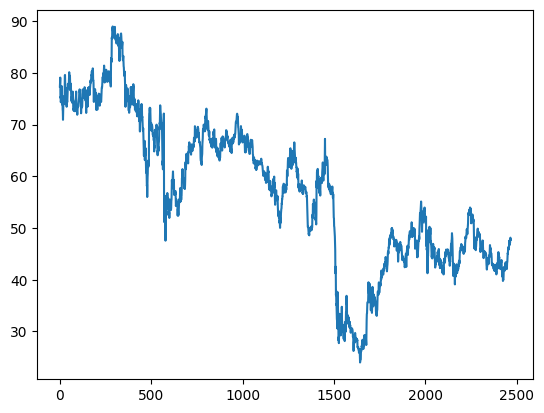

In [6]:
plt.plot(St)

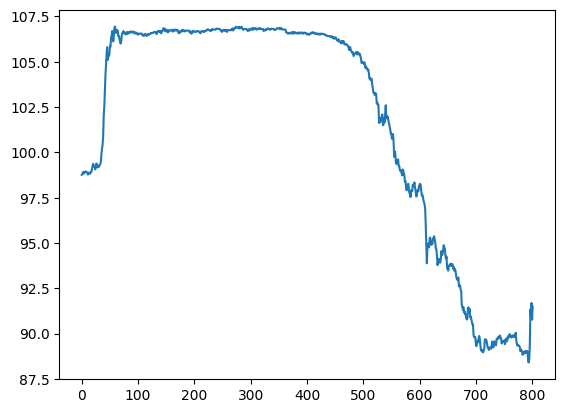

In [4]:
plt.plot(model_price)

Text(0.5, 1.0, 'Credit Suisse (Gov Intervention) (1/1/2020 -- 3/17/2023)')

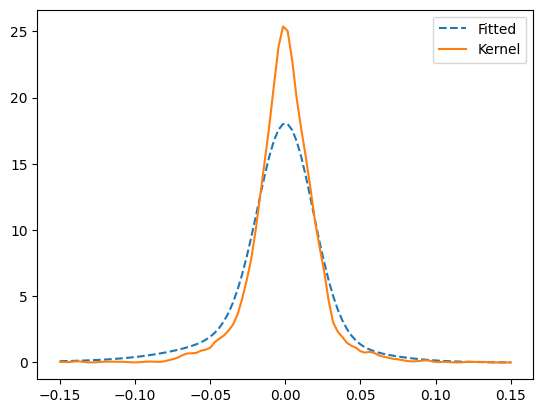

In [5]:

process_case = 'case4'
stock_param = pd.read_csv('../param/J_' + process_case + '.csv')
coco_param = pd.read_csv('../param/CoCo_' + process_case + '.csv')

loss, mu, sigma, l2, muV, sigmaV, eta, k1, xi1, k2, xi2, l32, l1, b, a = stock_param.iloc[0].values  
ignore_gov = False
pricing_period = ['1/1/2020', '3/17/2023']


data = pd.read_excel('../data/Credit_Suisse_Data_13-23.xlsx', sheet_name='Returns')
data = data.set_index('Names Date')

RET = data['Returns without Dividends']

RET_grids = np.linspace(-0.15, 0.15, 100)
Eval_Density = Density_stock(l1, a, b, mu, sigma, l2, muV, sigmaV, eta, RET_grids)
Data_DensityStock = KDE_estimate(RET.values, RET_grids)


plt.plot(RET_grids, Eval_Density, linestyle='--', label='Fitted')
plt.plot(RET_grids, Data_DensityStock, label='Kernel')
plt.legend()
ax.set_title(title + ' (' + pricing_period[0] + ' -- ' + pricing_period[1] + ')')